# Data analysis and estimation to precise walking distance distribution between Vincennes and La Défense.

1 - Read and prepare AFC, AVL data.

2 - Representation of egress times and trains arriving in Vincennes, from La Defense. 

Crossing with number of feasible run for each trip.

From a set of trips with only one feasible run:

3 - Quick estimation of mean and coefficient of variation for walking distance from observed egress time.

4 - Estimation of parameters with bi bariate gaussian distribution assumption.

5 - Estimation with assumption of log normal distributions.

In [1]:
from matplotlib import pyplot
from math import sqrt
from numpy import exp, log, mean, std
from pandas import Timestamp, read_csv, to_datetime
from scipy.stats import norm
from scipy import optimize

from data import Data

In [2]:
PATHS = "data/AVL-AFC-2015/"

### Read and prepare AFC data.

In [3]:
AFC_all = read_csv(PATHS + "AFC201503/16mars_rerA.txt", delimiter="\t")
AFC_all["LIBL_O"] = AFC_all["LIBL_O"].str.replace("-", "_")
AFC_all["LIBL_O"] = AFC_all["LIBL_O"].str.replace(" ", "_")
AFC_all["LIBL_D"] = AFC_all["LIBL_D"].str.replace("-", "_")
AFC_all["LIBL_D"] = AFC_all["LIBL_D"].str.replace(" ", "_")

AFC_all["index"] = AFC_all.index

AFC_all["H_O"] = AFC_all["JOUR_EXPL_VALD"] + " " + AFC_all["H_O"]
AFC_all["H_D"] = AFC_all["JOUR_EXPL_VALD"] + " " + AFC_all["H_D"]

AFC_all["H_O"] = to_datetime(AFC_all["H_O"], format="%d/%m/%Y %H:%M:%S")
AFC_all["H_D"] = to_datetime(AFC_all["H_D"], format="%d/%m/%Y %H:%M:%S")

### Read and prepare AVL data.

In [4]:
AVL_arrival_all = read_csv(PATHS + "AVL201503/AVL_arrivee_20150316.csv", encoding="latin-1", skiprows=[0, 1])
AVL_departure_all = read_csv(PATHS + "AVL201503/AVL_arrivee_20150316.csv", encoding="latin-1", skiprows=[0, 1])


### All trains and trip arrivals in La Defense.
In both directions... **filter trips in one direction ?**

In [5]:
# AVL_arrival_defense = AVL_arrival_all[(~AVL_arrival_all["DEF"].isna()) & (AVL_arrival_all["Voie"] == direction)].loc[:, ["DEF"]]
AVL_arrival_defense = AVL_arrival_all[(~AVL_arrival_all["DEF"].isna())].loc[:, ["DEF"]]

AVL_arrival_defense["DEF"] = "16/03/2015 " + AVL_arrival_defense["DEF"] 
AVL_arrival_defense = AVL_arrival_defense.applymap(to_datetime, errors="coerce", format="%d/%m/%Y %H:%M:%S")
AVL_arrival_defense = AVL_arrival_defense.dropna()

AVL_arrival_defense = AVL_arrival_defense.sort_values(by="DEF")

In [6]:
AFC_defense = AFC_all[AFC_all["LIBL_D"] == "LA_DEFENSE_GRANDE_ARCHE"]

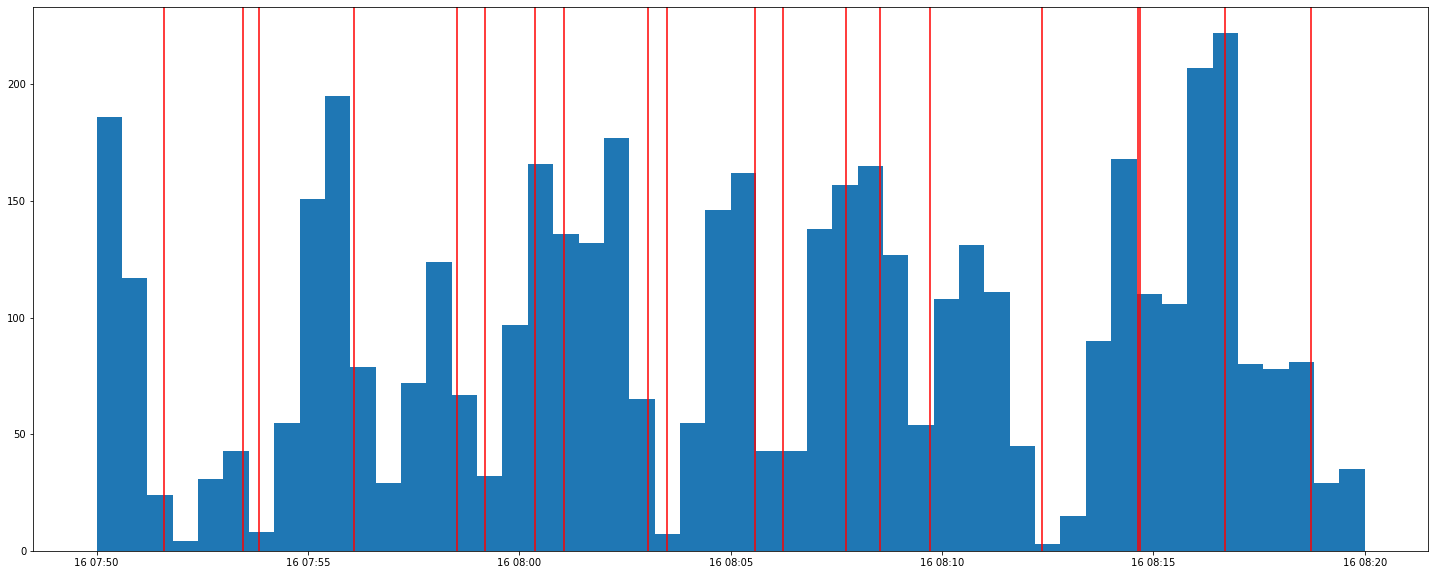

In [7]:
t_inf = Timestamp("16-03-2015 07:50")
t_sup = Timestamp("16-03-2015 08:20")

AVL_arrival_defense_time_window = AVL_arrival_defense[(AVL_arrival_defense["DEF"] >= t_inf) & (AVL_arrival_defense["DEF"] <= t_sup)]
AFC_defense_time_window = AFC_defense[(AFC_defense["H_D"] >= t_inf) & (AFC_defense["H_D"] <= t_sup)]

pyplot.rcParams["figure.figsize"] = [25, 10]

pyplot.hist(AFC_defense_time_window["H_D"], bins=50)
for x in AVL_arrival_defense_time_window["DEF"]:
    pyplot.axvline(x, color='red')


## Between Vincennes and la Defense.

In [8]:
direction = 2

AVL_arrival_defense_from_vincennes = AVL_arrival_all[(~AVL_arrival_all["DEF"].isna()) & (~AVL_arrival_all["VIN"].isna()) & (AVL_arrival_all["Voie"] == direction)].loc[:, ["DEF"]]

AVL_arrival_defense_from_vincennes["DEF"] = "16/03/2015 " + AVL_arrival_defense_from_vincennes["DEF"] 
AVL_arrival_defense_from_vincennes = AVL_arrival_defense_from_vincennes.applymap(to_datetime, errors="coerce", format="%d/%m/%Y %H:%M:%S")
AVL_arrival_defense_from_vincennes = AVL_arrival_defense_from_vincennes.dropna()

AVL_arrival_defense_from_vincennes = AVL_arrival_defense_from_vincennes.sort_values(by="DEF")


In [9]:
AFC_vincennes_defense = AFC_all[(AFC_all["LIBL_D"] == "LA_DEFENSE_GRANDE_ARCHE") & (AFC_all["LIBL_O"] == "VINCENNES")]

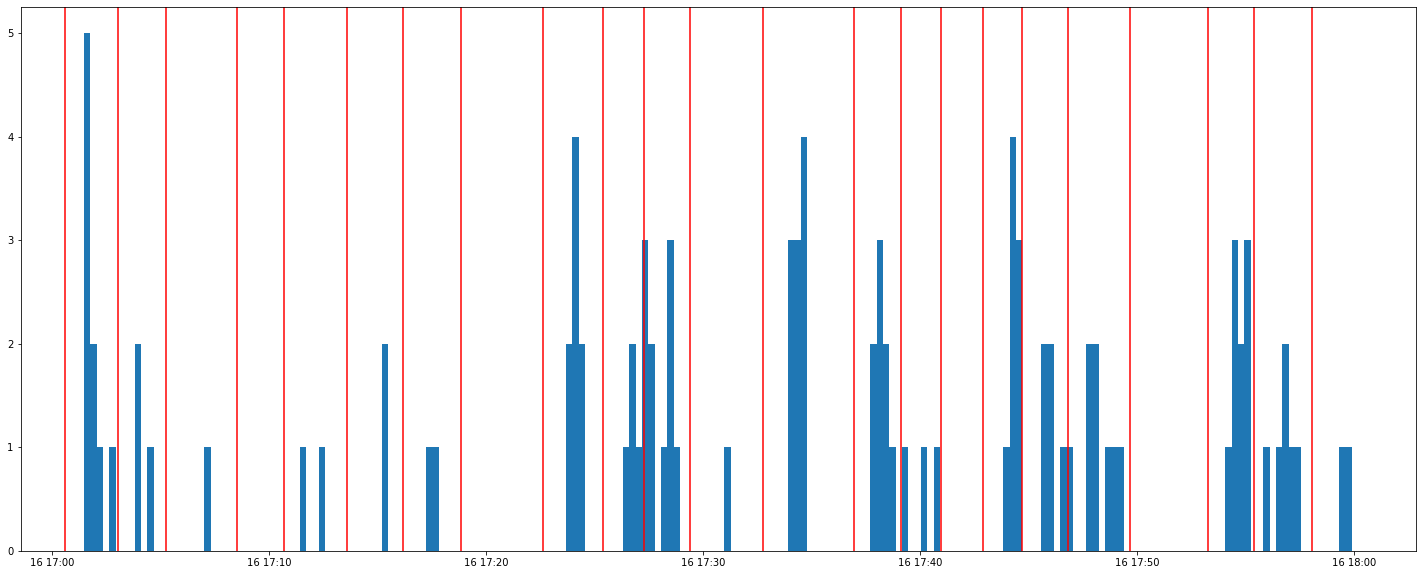

In [10]:
t_inf = Timestamp("16-03-2015 17:00")
t_sup = Timestamp("16-03-2015 18:00")

AVL_arrival_vin_def_time_window = AVL_arrival_defense_from_vincennes[(AVL_arrival_defense_from_vincennes["DEF"] >= t_inf) & (AVL_arrival_defense_from_vincennes["DEF"] <= t_sup)]
AFC_vin_def_time_window = AFC_vincennes_defense[(AFC_vincennes_defense["H_D"] >= t_inf) & (AFC_vincennes_defense["H_D"] <= t_sup)]

pyplot.rcParams["figure.figsize"] = [25, 10]

pyplot.hist(AFC_vin_def_time_window["H_D"], bins=200)
for x in AVL_arrival_vin_def_time_window["DEF"]:
    pyplot.axvline(x, color='red')

### Crossing with feasible runs.

In [11]:
PATHS = "data/AVL-AFC-2015/"
station_origin = "VINCENNES"
station_destination = "LA_DEFENSE_GRANDE_ARCHE"
date = "2015-03-16"
direction = "west"

data = Data(PATHS, date, direction, station_origin, station_destination)

data.compute_feasible_runs()

Computing feasible runs...


100%|██████████| 1333/1333 [00:01<00:00, 987.00it/s] 


In [12]:
print(len(data.feasible_runs_dict))
AFC_vincennes_defense.info

2646


<bound method DataFrame.info of                    NUMR_CART JOUR_EXPL_VALD                 H_O     LIBL_O  \
71      59430226021026333183     16/03/2015 2015-03-16 04:46:37  VINCENNES   
759     54875173604413962351     16/03/2015 2015-03-16 05:12:50  VINCENNES   
1035    31787636810494168072     16/03/2015 2015-03-16 05:16:16  VINCENNES   
1049    41126004618237327245     16/03/2015 2015-03-16 05:16:26  VINCENNES   
1388    05228325971886791873     16/03/2015 2015-03-16 05:22:06  VINCENNES   
...                      ...            ...                 ...        ...   
517612  95468227531846264666     16/03/2015 2015-03-16 21:54:07  VINCENNES   
518210  62574579237486122203     16/03/2015 2015-03-16 22:01:07  VINCENNES   
522613  26396030186319463028     16/03/2015 2015-03-16 22:51:47  VINCENNES   
522615  44923373970868724899     16/03/2015 2015-03-16 22:51:49  VINCENNES   
522831  10135276111862398250     16/03/2015 2015-03-16 22:54:28  VINCENNES   

                       H_D     

In [67]:
feasible_runs = []
for trip_id in AFC_vincennes_defense.index:
    try: 
        feasible_runs.append(data.feasible_runs_dict["last_feasible_run", trip_id] - data.feasible_runs_dict["first_feasible_run", trip_id] + 1)
    except KeyError:
        feasible_runs.append(0)

AFC_vincennes_defense["Feasible_run"] = feasible_runs

1333


/tmp/ipykernel_34718/2617802417.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AFC_vincennes_defense["Feasible_run"] = feasible_runs


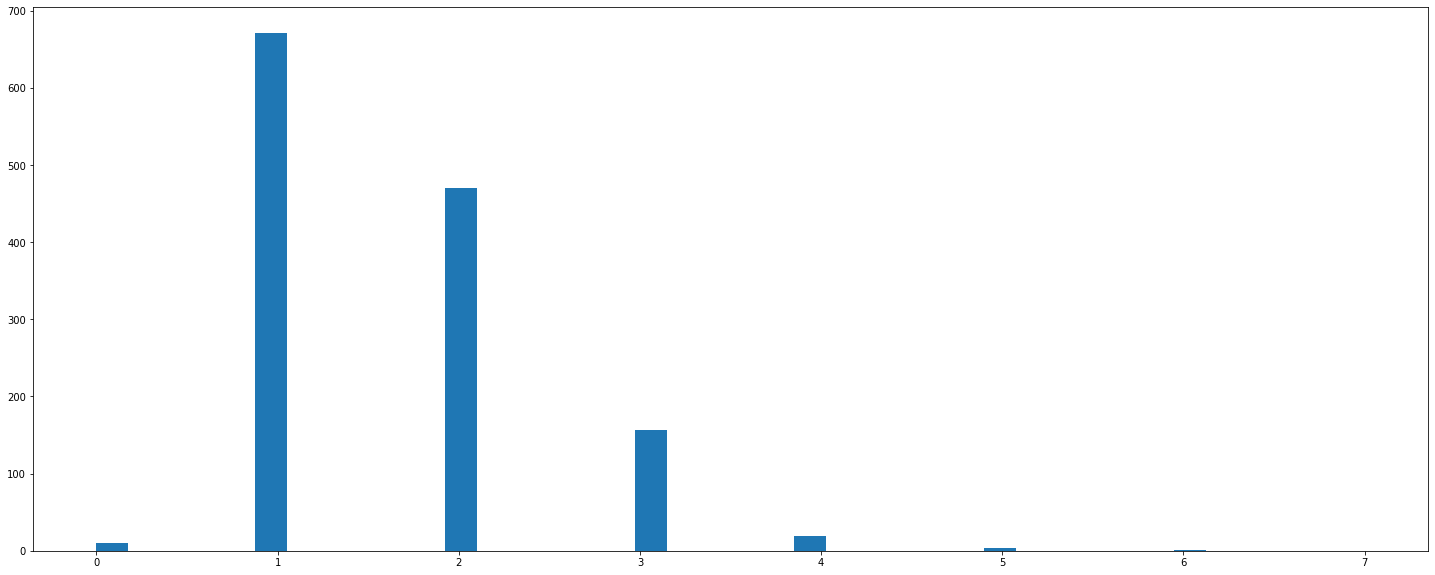

In [76]:
pyplot.rcParams["figure.figsize"] = [25, 10]
fig,ax = pyplot.subplots()
# ax.set_xlabel("Number of feasible runs.")

ax.hist(feasible_runs, bins=40, range=(0,7))
pyplot.show()

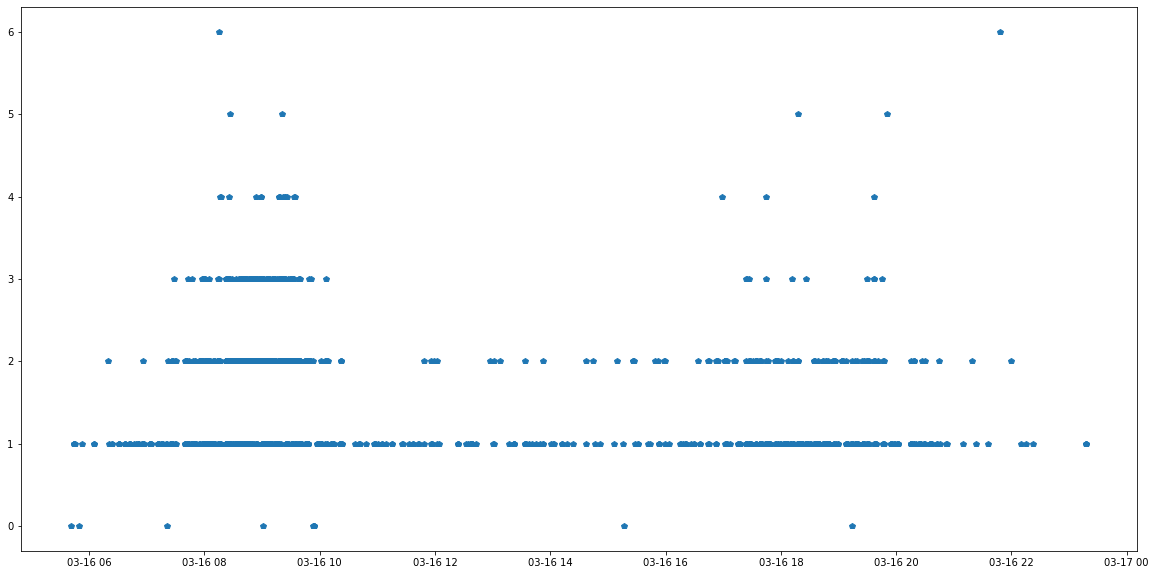

In [14]:
pyplot.rcParams["figure.figsize"] = [20, 10]
pyplot.plot(AFC_vincennes_defense["H_D"], [min(nbr,6) for nbr in feasible_runs], 'p')
pyplot.show()

In [15]:
t_inf = Timestamp("16-03-2015 7:30")
t_sup = Timestamp("16-03-2015 8:30")

AVL_arrival_vin_def_time_window = AVL_arrival_defense_from_vincennes[(AVL_arrival_defense_from_vincennes["DEF"] >= t_inf) & (AVL_arrival_defense_from_vincennes["DEF"] <= t_sup)]
AFC_vin_def_time_window = AFC_vincennes_defense[(AFC_vincennes_defense["H_D"] >= t_inf) & (AFC_vincennes_defense["H_D"] <= t_sup)]


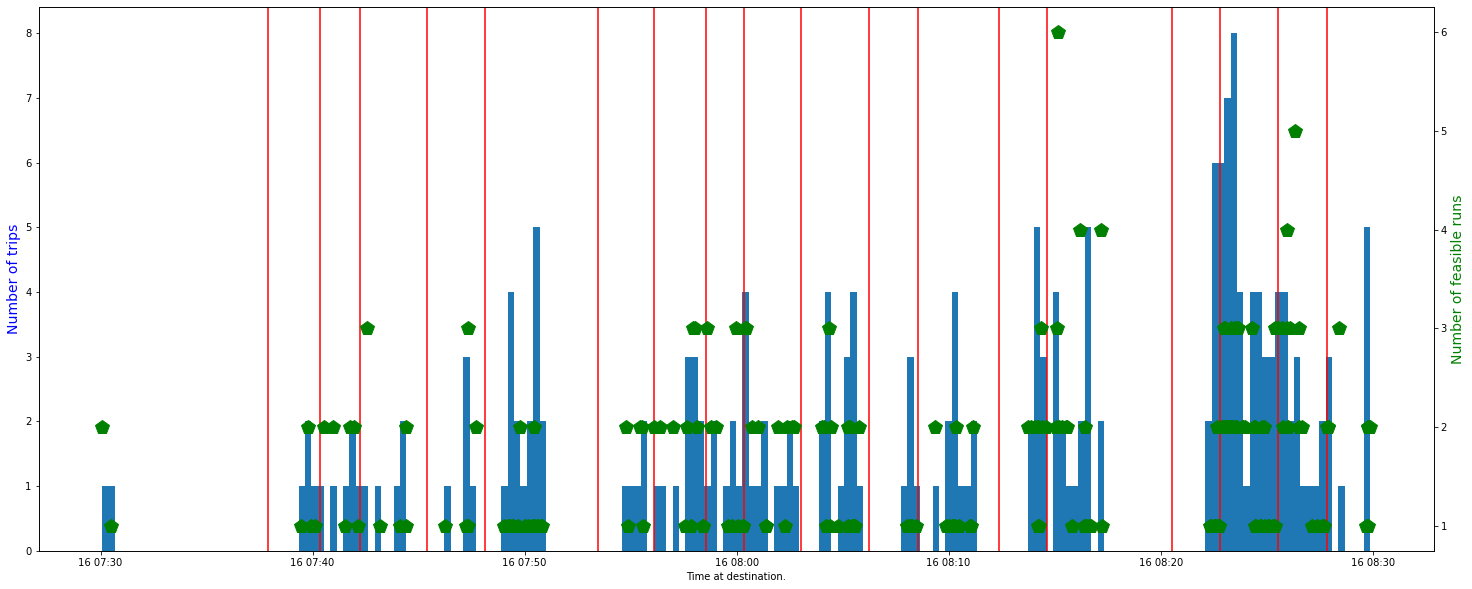

In [16]:
pyplot.rcParams["figure.figsize"] = [25, 10]
fig,ax = pyplot.subplots()
ax.set_xlabel("Time at destination.")
ax2=ax.twinx()

ax.hist(AFC_vin_def_time_window["H_D"], bins=200)
ax.set_ylabel("Number of trips",fontsize=14, color = "blue")

ax2.plot(AFC_vin_def_time_window["H_D"], AFC_vin_def_time_window["Feasible_run"],'p', markersize=14, color = "green")
ax2.set_ylabel("Number of feasible runs",fontsize=14, color="green")

for x in AVL_arrival_vin_def_time_window["DEF"]:
    ax.axvline(x, color='red')

### Walking distance in La Defense from Vincennes when $n_{\text{feasible runs}} = 1$.

In [66]:
AVL_arrival_defense_from_vincennes = AVL_arrival_defense_from_vincennes.reset_index(drop=True)

walking_time_egress = []
for trip_id in AFC_vincennes_defense.index:
    if AFC_vincennes_defense.loc[trip_id,"Feasible_run"] == 2:
        feasible_run = data.feasible_runs_dict["first_feasible_run", trip_id]
        walking_time = (AFC_vincennes_defense.loc[trip_id,"H_D"] - AVL_arrival_defense_from_vincennes.loc[feasible_run,"DEF"]).total_seconds()
        walking_time_egress.append(walking_time)

    # if AFC_vincennes_defense.loc[trip_id,"Feasible_run"] == 2:
    #     feasible_run = data.feasible_runs_dict["first_feasible_run", trip_id] + 1
    #     walking_time = (AFC_vincennes_defense.loc[trip_id,"H_D"] - AVL_arrival_defense_from_vincennes.loc[feasible_run,"DEF"]).total_seconds()

    # if (walking_time > 30) and (walking_time < 200):
    #     walking_time_egress.append(walking_time)


157


[]

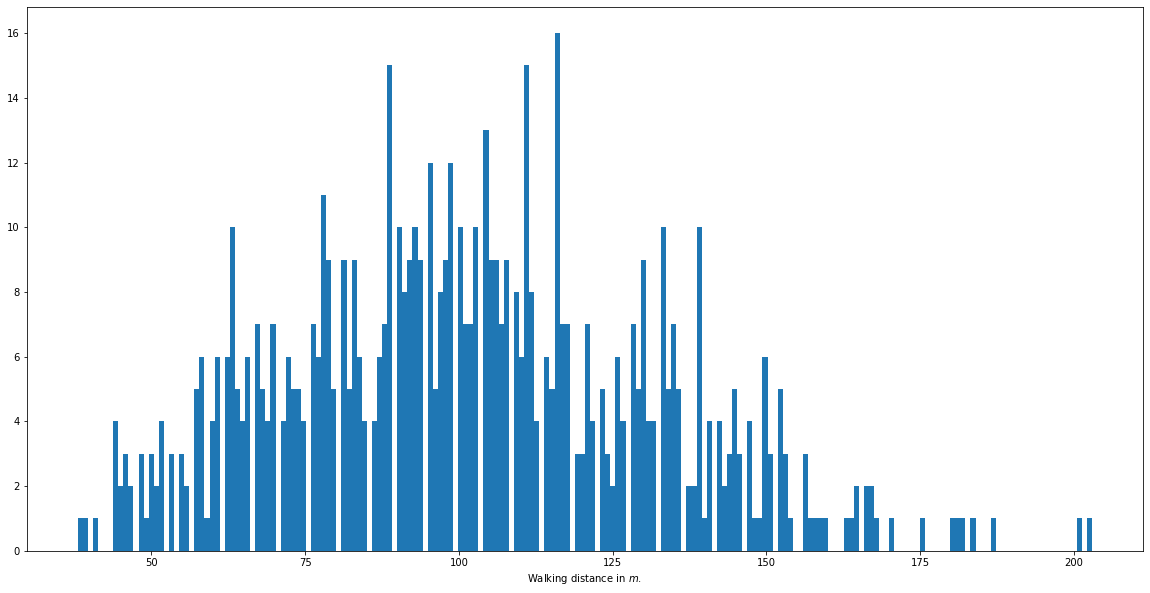

In [18]:
pyplot.rcParams["figure.figsize"] = [20, 10]
fig,ax = pyplot.subplots()
ax.set_xlabel("Walking distance in $m$.")

ax.hist(walking_time_egress, bins=200)
# ax.set_ylabel("Distribution.",fontsize=14, color = "blue")
ax.plot()

### Quick estimation of free flow walk length.
We assume that the walk speeds are distributed between $3$ and $6$ km/h, then $E_w =  1.2$ m/s and $SD_w = .2$ m/s, then $\gamma_w ≈.17$ is sufficiently small and $\gamma_{w^{-1}} = 3 \%$.
Thus we estimate in meter and second:
$ E_{l} = 1.2 . E_{\tau}$,
$\gamma_l^2 = \gamma_{\tau}^2 - 3 \% $.

**Question:** Validation of hypothesis on walk speed distribution ? 

In [19]:
egress_time_mean = mean(walking_time_egress)
egress_time_std = std(walking_time_egress)
print(egress_time_std)

29.694260592615603


In [20]:
egress_distance_mean = 1.2 * egress_time_mean
egress_distance_cv = sqrt((egress_time_std/egress_time_mean)**2 - 0.03)
egress_distance_std = egress_distance_mean*egress_distance_cv
print(egress_distance_mean)
print(egress_distance_std)

121.86706408345752
28.708383483489097


**Question:** Why not directly consider egress time distribution ?? see in the litterature

### MLE of free flow egress time with bivariate Gaussian vector for walking speed and distance.
Taking egress time of off-peak trips (ensuring free flow condition) and with one feasible run.

The egress time PDF reads $ \dot{T}(x) = \int w \dot{S}_w (w.x) dW(w)$, assuming $w \geq 0 $ and $w$ and $l$ statistically independant.

- What does it mean to look for correlated Gaussian distributions ?

- Check ex-post that speeds almost certain positive.

In [34]:
def egress_time_likelihood_gaussian(distance_mean, distance_sd, speed_mean, speed_sd, covariance, x):
    y_x = sqrt(distance_sd**2 + (x*speed_sd)**2 +  - 2*x*covariance)
    phi = norm.pdf((x*speed_mean - distance_mean)/y_x)
    num = speed_mean*(distance_sd**2 - x*covariance) + distance_mean*(x*speed_sd**2 - covariance)
    denom = y_x**3
    return num*phi/denom

In [49]:
def sum_log_likelihood(param, covariance):
    log_likelihood = 0
    for egress_time in walking_time_egress:
        log_likelihood -= log(egress_time_likelihood_gaussian(param[0], param[1], param[2], param[3], covariance, egress_time))
    # print(log_likelihood)
    return log_likelihood

In [50]:
parameters_optimal = optimize.minimize(
    sum_log_likelihood,
    (120,1,1, 0.05),
    method="Powell",
    args=(0),
    bounds=[(0, None), (0,None), (0,None), (0, None)]
).x


In [51]:
print(parameters_optimal)

[91.73886854 24.08569994  0.91686012  0.10994355]


for $m_w = 1.2$: 

with L-BFGS-B (default): 9.2s, $m_l = 119$, $\sigma_l = 25.6$, $\sigma_w = 3.34 . 10^{-2}$, $\chi = -2.81$

for $\chi = 0$ : $m_l = 91.7$, $\sigma_l = 24.1$, $m_w = 0.917 $, $\sigma_w = 0.110$



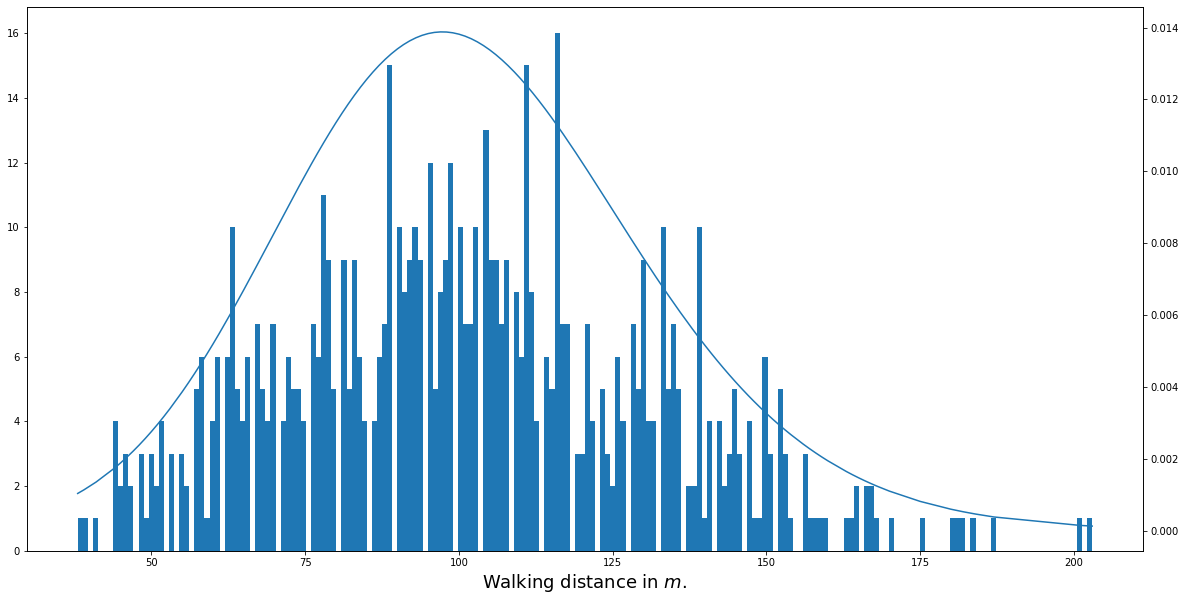

In [52]:
pyplot.rcParams["figure.figsize"] = [20, 10]
fig,ax = pyplot.subplots()
ax.set_xlabel("Walking distance in $m$.")

ax.hist(walking_time_egress, bins=200)
# ax.set_ylabel("Distribution.",fontsize=14, color = "blue")

walking_time_egress.sort()

estimated_distrib = [egress_time_likelihood_gaussian(parameters_optimal[0], parameters_optimal[1], parameters_optimal[2], parameters_optimal[3],0, y) for y in walking_time_egress]

ax2=ax.twinx()
ax2.plot(walking_time_egress, estimated_distrib)

#### Asymptotic confidence interval.
Compute Hessian of total log-likelihood, evaluate at optimal parameters.

In [60]:
from numdifftools import Hessian

In [59]:
parameters = [120, 32.2, 0.132]
def one_likelihood_term(param, speed, covariance, x):
    return egress_time_likelihood_gaussian(param[0], param[1], speed, param[2], covariance, x)

hess = Hessian(one_likelihood_term)

sum_hessian = [[0 for _ in range(len(parameters))] for _ in range(len(parameters))]
for x in walking_time_egress:
    sum_hessian += hess(parameters, 1.2, 0, x)

print(sum_hessian)

[[-2.45677956e-03  4.73131533e-04 -1.23830138e-02]
 [ 4.73131533e-04  3.70875256e-04  1.24526148e-01]
 [-1.23830138e-02  1.24526148e-01 -2.05373384e+01]]


### Estimation of free flow egress distribution with log-normal distribution for walking distance and speed.
Taking egress time of off-peak trips (ensuring free flow condition) and with one feasible run.

The egress time PDF reads $ \dot{T}(x) = \frac{1}{\sigma_{\tau}x} \phi \left( \frac{\ln(x)- \mu_{\tau}}{\sigma_{\tau}} \right)$, assuming $w \geq 0 $ but no statistical independance.

$\mu_{\tau} = \frac{1}{A} \sum \tilde{\tau}_u$

$\sigma_{\tau}^2 = \frac{1}{A} \sum (\tilde{\tau}_u - \mu_{\tau})^2 $


In [26]:
egress_time_log_mean = mean(log(walking_time_egress))
egress_time_log_std = sqrt(mean([(time - egress_time_log_mean)**2 for time in log(walking_time_egress)]))
print(egress_time_log_mean)
print(egress_time_log_std)

4.575351992562579
0.30791438021623824


In [27]:
walking_mean_log = log(1.2)
walking_std_log = log(0.35)
distance_mean_log =  egress_time_log_mean - walking_mean_log
diff_log = egress_distance_std**2 - walking_std_log**2


In [28]:
def log_egress_time_distribution(x, mean, std):
    frac = 1/(std*x)
    phi = norm.pdf((log(x)-mean)/std)
    return frac*phi

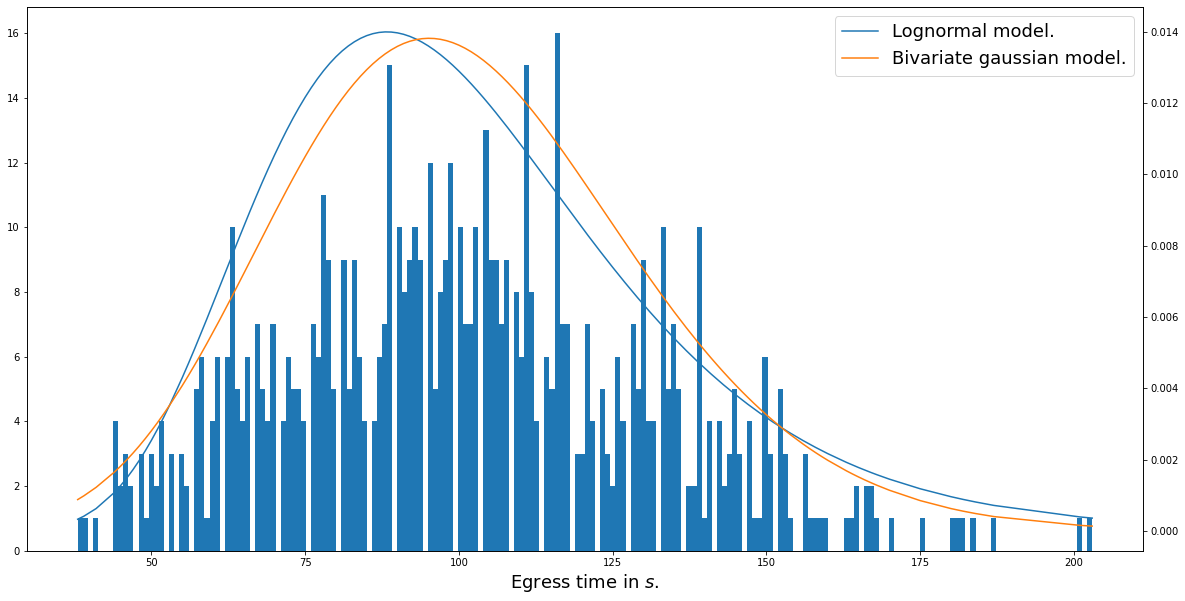

In [29]:
pyplot.rcParams["figure.figsize"] = [20, 10]
pyplot.rc('legend', fontsize=18)  
pyplot.rc('axes', labelsize=18)   
fig,ax = pyplot.subplots()
ax.set_xlabel("Egress time in $s$.")

ax.hist(walking_time_egress, bins=200)

walking_time_egress.sort()
ax2=ax.twinx()
ax2.plot(walking_time_egress, [log_egress_time_distribution(time, egress_time_log_mean, egress_time_log_std) for time in walking_time_egress], label="Lognormal model.")

estimated_distrib_gaussian = [egress_time_likelihood_gaussian(parameters_optimal[0], parameters_optimal[1], 1.2, parameters_optimal[2], parameters_optimal[3],y) for y in walking_time_egress]
ax2.plot(walking_time_egress, estimated_distrib_gaussian, label="Bivariate gaussian model.")
ax2.legend(loc ="upper right")